# **Objective**- Apply DecisionTreeClassifier on amazon fine food review

#### **About the dataset**

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454 
* Number of users: 256,059 
* Number of products: 74,258 
* Timespan: Oct 1999 - Oct 2012 
* Number of Attributes/Columns in data: 10

##### **Attribute Information**:

1. Id ProductId - unique identifier for the product 
2. UserId - unqiue identifier for the user ProfileName 
3. HelpfulnessNumerator - number of users who found the review helpful 
4. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not 
5. Score - rating between 1 and 5 
6. Time - timestamp for the review 
7. Summary - brief summary of the review 
8. Text - text of the review

#### **Codes for--**

* Applying GridSearchCV with scoring='f1' and 'accuracy',  on DecisionTreeClassifier for all the four vectorizer- Bow, Tfidf, Avg word2vec and Tfidf word2vec.


## **1. Loading and preprocessing the data**

In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import sqlite3
import numpy as np
import pandas as pd

In [7]:
sql_data=sqlite3.connect('database.sqlite')
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql_data)

In [8]:
def pos_neg(x):
    if x<3:
        return 0
    else:
        return 1
data['Score']=data['Score'].map(pos_neg)

In [9]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)  #dropping the duplicates in the datasets

In [10]:
data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [11]:
#sampling the data
data=data.sort_values(['Time'])#time based sorting 


In [12]:
import nltk
from nltk.corpus import stopwords
import re

stop=set(stopwords.words('english'))   #stopwords of english language
sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
#filtering sentence
final_string=[]
s=''
for sentence in data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [14]:
data['Cleaned_text']=final_string


In [59]:
data.to_csv('data.csv')

In [5]:
data=pd.read_csv('data.csv')

In [6]:
len(data)

364171

##### ** Observation- Taking the whole datapoints**

In [8]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(data['Cleaned_text'], data['Score'], test_size=0.3, shuffle=False) #splitting the data

#### **User-defined function**

In [9]:
#this function finds max depth hyperparameter using GridSearchCV, accuracy, plot mse vs depth, confusion matrix and classification report
# this function returns accuracy, optimal depth, TNR, TPR, FNR, FPR

from scipy.stats import randint

def cross_val(scoring, n_jobs, x_train, x_test, y_train=y_train, y_test=y_test, n=16):
    #depth=sorted(randint(1,400).rvs(n))
    depth=list(range(1,n))
    cv_score=[]
    start=datetime.now()
    param={'max_depth':depth}
    tscv=TimeSeriesSplit(n_splits=10)
    clf=DecisionTreeClassifier()
    clf=GridSearchCV(estimator=clf, param_grid=param, scoring=scoring, n_jobs=n_jobs, cv=tscv, verbose=1)
    clf.fit(x_train,y_train)
    end=datetime.now()
    print('duration in cross validation=',(end-start))
    print('**********************************************************************\n')
    optimal_depth=clf.best_estimator_.get_params()['max_depth']
    print('optimal depth',optimal_depth)
    
    print('**********************************************************************\n')
        
    # finding precision error and optimal depth
    mse=[]
    for x in clf.grid_scores_:
        mse.append(1-x[1])
    
    #ploting precision error vs depth
    plt.figure(figsize=(8,8))
    plt.plot(depth,mse)
    plt.xlabel('depth')
    plt.ylabel('misclassification error')
    plt.title('plot between depth vs error')
    plt.show()
    print('**********************************************************************\n')
    
        
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_test,y_pred)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
      
    
    return optimal_depth, accu, TNR, TPR, FPR, FNR

## **2. Bag of Words**

In [10]:

count_vec=CountVectorizer()
x_train_bow=count_vec.fit_transform(X.values)
x_test_bow=count_vec.transform(x_test.values)

In [12]:
print('number of dimensions in unigram bag of words = ',len(count_vec.get_feature_names()))


number of dimensions in unigram bag of words =  51033


### **2.1 Apply GridSearchCV, scoring='accuracy', on DecisionTreeClassifier for BoW**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  7.2min finished


duration in cross validation= 0:07:31.090198
**********************************************************************

optimal depth 13
**********************************************************************



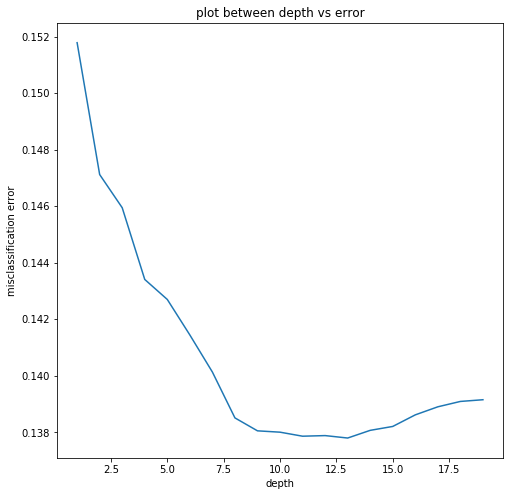

**********************************************************************

accuracy= 84.7792260095925
**********************************************************************

confusion matrix--


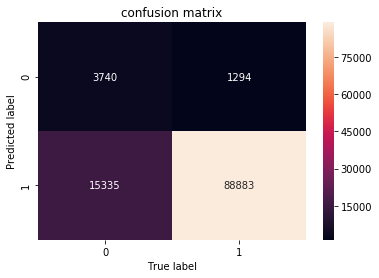

**********************************************************************

TNR= 0.19606815203145478
TPR= 0.985650443017621
FPR= 0.8039318479685452
FNR= 0.0143495569823791
**********************************************************************

             precision    recall  f1-score   support

          0       0.20      0.74      0.31      5034
          1       0.99      0.85      0.91    104218

avg / total       0.95      0.85      0.89    109252

**********************************************************************



In [18]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, scoring='accuracy', n_jobs=-1, x_train=x_train_bow, x_test=x_test_bow)

**Feature Importance**

In [19]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_bow,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count_vec.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
keep 		:		 0.00387
hope 		:		 0.00398
review 		:		 0.00427
favorit 		:		 0.00477
littl 		:		 0.00483
money 		:		 0.0053
use 		:		 0.00592
would 		:		 0.00609
refund 		:		 0.00654
horribl 		:		 0.0076
tast 		:		 0.00868
thought 		:		 0.01893
descript 		:		 0.01941
delici 		:		 0.02503
perfect 		:		 0.02521
good 		:		 0.02629
bad 		:		 0.03065
threw 		:		 0.04581
best 		:		 0.06135
love 		:		 0.06841
return 		:		 0.06909
worst 		:		 0.07641
wast 		:		 0.09485
great 		:		 0.09685
disappoint 		:		 0.1113


### **2.2 Apply GridSearchCV, scoring='f1', on DecisionTreeClassifier for BoW**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  7.2min finished


duration in cross validation= 0:07:22.552471
**********************************************************************

optimal depth 10
**********************************************************************



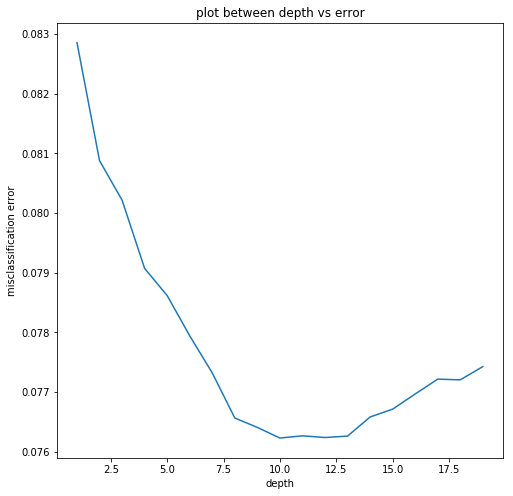

**********************************************************************

accuracy= 84.67488009372826
**********************************************************************

confusion matrix--


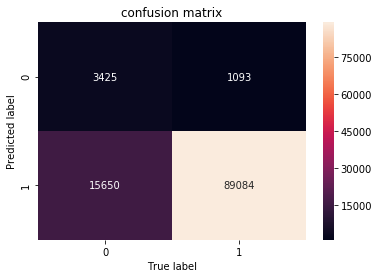

**********************************************************************

TNR= 0.17955439056356487
TPR= 0.9878793927498143
FPR= 0.8204456094364351
FNR= 0.012120607250185746
**********************************************************************

             precision    recall  f1-score   support

          0       0.18      0.76      0.29      4518
          1       0.99      0.85      0.91    104734

avg / total       0.95      0.85      0.89    109252

**********************************************************************



In [16]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, scoring='f1', n_jobs=-1, x_train=x_train_bow, x_test=x_test_bow)

**Feature Importance**

In [17]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_bow,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count_vec.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
ever 		:		 0.0025
earth 		:		 0.00282
delici 		:		 0.0029
home 		:		 0.00307
hope 		:		 0.00324
date 		:		 0.00382
keep 		:		 0.00412
year 		:		 0.00432
favorit 		:		 0.00537
use 		:		 0.00576
littl 		:		 0.00588
money 		:		 0.00646
tast 		:		 0.00752
refund 		:		 0.00836
thought 		:		 0.01631
good 		:		 0.02763
bad 		:		 0.03785
threw 		:		 0.05558
best 		:		 0.07413
love 		:		 0.08287
return 		:		 0.08424
worst 		:		 0.09253
wast 		:		 0.11565
great 		:		 0.11767
disappoint 		:		 0.13572


#### **Observation-**
* we can choose max_depth=13 as a best hyperparameter for BoW

**saving graph**

In [13]:
import graphviz
from sklearn import tree
clf=DecisionTreeClassifier(max_depth=13)
clf.fit(x_train_bow,y_train)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("graph_bow.pdf") 


'graph_bow.pdf.pdf'

## **3. TFIDF**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf_vect.fit_transform(X.values)
x_test_tfidf=tfidf_vect.transform(x_test.values)

In [34]:
print('number of dimensions in tfidf = ',len(tfidf_vect.get_feature_names()))

number of dimensions in tfidf =  51033


### **3.1 Apply GridSearchCV, scoring='accuracy', on DecisionTreeClassifier for TFIDF**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.5min finished


duration in cross validation= 0:09:48.940336
**********************************************************************

optimal depth 10
**********************************************************************



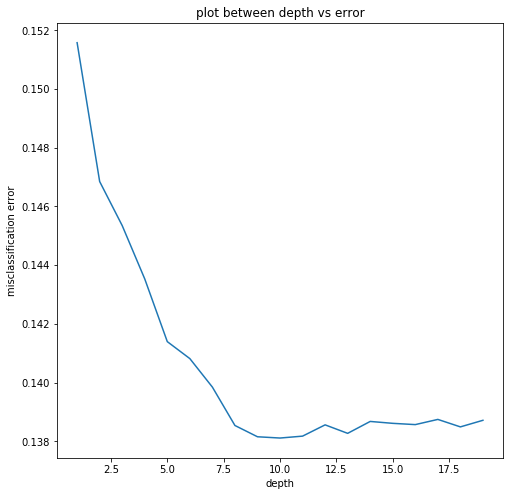

**********************************************************************

accuracy= 84.65382784754513
**********************************************************************

confusion matrix--


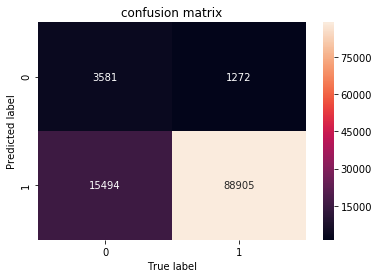

**********************************************************************

TNR= 0.18773263433813892
TPR= 0.9858944076649256
FPR= 0.8122673656618611
FNR= 0.014105592335074354
**********************************************************************

             precision    recall  f1-score   support

          0       0.19      0.74      0.30      4853
          1       0.99      0.85      0.91    104399

avg / total       0.95      0.85      0.89    109252

**********************************************************************



In [35]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, scoring='accuracy', n_jobs=-1,  x_train=x_train_tfidf, x_test=x_test_tfidf)

**Feature Importance**

In [36]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_tfidf,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf_vect.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
wont 		:		 0.00221
home 		:		 0.00235
receiv 		:		 0.00237
find 		:		 0.00272
use 		:		 0.00273
ever 		:		 0.00328
favorit 		:		 0.00328
earth 		:		 0.00329
would 		:		 0.00344
enjoy 		:		 0.00398
littl 		:		 0.00448
date 		:		 0.00479
money 		:		 0.00667
tast 		:		 0.01303
thought 		:		 0.01761
good 		:		 0.02805
bad 		:		 0.04103
threw 		:		 0.05765
best 		:		 0.07099
return 		:		 0.08522
love 		:		 0.08983
worst 		:		 0.09191
great 		:		 0.11788
wast 		:		 0.11818
disappoint 		:		 0.13316


### **3.2 Apply GridSearchCV, scoring='f1', on DecisionTreeClassifier for TFIDF**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.6min finished


duration in cross validation= 0:09:56.806488
**********************************************************************

optimal depth 9
**********************************************************************



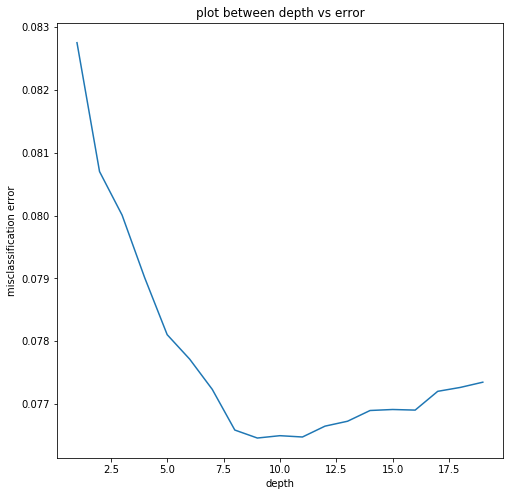

**********************************************************************

accuracy= 84.62728371105335
**********************************************************************

confusion matrix--


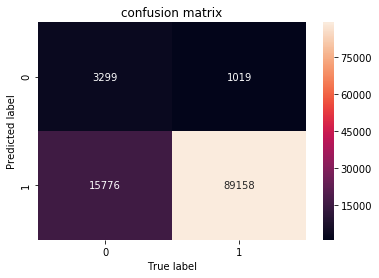

**********************************************************************

TNR= 0.17294888597640892
TPR= 0.9887000011089302
FPR= 0.8270511140235911
FNR= 0.011299998891069784
**********************************************************************

             precision    recall  f1-score   support

          0       0.17      0.76      0.28      4318
          1       0.99      0.85      0.91    104934

avg / total       0.96      0.85      0.89    109252

**********************************************************************



In [37]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, n_jobs=-1, scoring='f1', x_train=x_train_tfidf, x_test=x_test_tfidf)

**Feature Importance**

In [38]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_tfidf,y_train)
print('top 25 words and their IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf_vect.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
year 		:		 0.00223
home 		:		 0.00227
wont 		:		 0.00239
would 		:		 0.00248
receiv 		:		 0.00255
make 		:		 0.00256
find 		:		 0.00293
use 		:		 0.00294
favorit 		:		 0.00327
ever 		:		 0.00333
earth 		:		 0.00338
littl 		:		 0.00362
date 		:		 0.00433
money 		:		 0.00732
tast 		:		 0.00904
thought 		:		 0.01887
bad 		:		 0.04203
threw 		:		 0.06089
best 		:		 0.07403
return 		:		 0.0919
love 		:		 0.09646
worst 		:		 0.09912
great 		:		 0.1268
wast 		:		 0.12744
disappoint 		:		 0.14376


#### **Observation-**
* we can choose max_depth=10 as a best hyperparameter for BoW

**saving graph**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf_vect.fit_transform(X.values)
x_test_tfidf=tfidf_vect.transform(x_test.values)

In [15]:
import graphviz 
clf=DecisionTreeClassifier(max_depth=10)
clf.fit(x_train_tfidf,y_train)
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("graph_tfidf") 


'graph_tfidf.pdf'

## **4. Avg word2vec**

In [39]:
!wget --header="Host: e-6bc70e55d4.cognitiveclass.ai" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: _ga=GA1.2.1408782138.1533706215; _vwo_uuid_v2=D808F3746C7D13DF10604B0467CB47E6F|7e911a739f7499117f301311475e9849; optimizelyEndUserId=oeu1535058107427r0.5772861613267186; BMAID=24e17573-cc55-4f8c-8e60-f9e9d3ef3085; ajs_user_id=null; ajs_group_id=null; ajs_anonymous_id=%2224e17573-cc55-4f8c-8e60-f9e9d3ef3085%22; OPTOUTMULTI=0:0%7Cc1:1%7Cc2:0%7Cc3:0; CoreID6=90053287940815354313144&ci=50200000|IBMTESTWWW; CoreM_State=73~-1~-1~-1~-1~3~3~5~3~3~7~7~|~~|~~|~~|~||||||~|~~|~~|~~|~~|~~|~~|~~|~; CoreM_State_Content=6~|~~|~|; utag_main=v_id:01656897e5a20021d387f580130803068001a0600086e$_sn:2$_ss:0$_st:1535433114916$ses_id:1535431312273%3Bexp-session$_pn:1%3Bexp-session$is_country_member_of_eu:false$dc_visit:1$dc_event:1%3Bexp-session$mm_sync:1%3Bexp-session$dc_region:ap-northeast-1%3Bexp-session; _xsrf=2|58dc3bb5|e37d8b1be742934a7d48958ff328ba7b|1536734305; _gid=GA1.2.1452287113.1537210647; username=anshuak100; _gat=1; session=.eJxVjmFrglAYhf_KeD9LaGapEMzSak1NicwaQ255U6de3fXqZtF_n45B7Ns5B55zzg2CEtMcEUwYqIzWmANUszhgRYoJqDd46vI3aNFQGSwzPppF6ENr9QOTG11jL-y4W5n-uMM_451Q6hMtyG1pW20qZ6bLm3HYWuFyFBsiWVzt8nsv4jndslwuede8vuqWfxZxVJx8a8movJZagxTU3J59C090U74kjug4h9Q4rsydBVz35gQqwP39zkGFMvZ7sI_CfTb0fK1xU6nFxqLxfFtyhXXhEY8cr7wyj6ZT6KC6wjRIyKXoSZyjJOtgRKq4RqnA889RHw3ORQ4cXBJasYCgHPebHGTon32ovvTPPar6ta9TkISgKvxIGd9_AC5mdWo.DoeoiQ.cz73U0xnq5FK596B0UoEYh9pmPY" --header="Connection: keep-alive" "https://e-6bc70e55d4.cognitiveclass.ai/files/GoogleNews-vectors-negative300.bin.gz" -O "GoogleNews-vectors-negative300.bin.gz" -c

--2018-09-22 10:19:32--  https://e-6bc70e55d4.cognitiveclass.ai/files/GoogleNews-vectors-negative300.bin.gz
Resolving e-6bc70e55d4.cognitiveclass.ai (e-6bc70e55d4.cognitiveclass.ai)... 169.55.145.204, 169.53.184.237
Connecting to e-6bc70e55d4.cognitiveclass.ai (e-6bc70e55d4.cognitiveclass.ai)|169.55.145.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  10.6MB/s    in 3m 2s   

2018-09-22 10:22:34 (8.65 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [16]:
sample_data=data.iloc[:100000]  #taking 100k datapoints
sample_score=sample_data['Score']

##### ** Observation- Taking first 100k datapoints**

In [17]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3, shuffle=False) #splitting the data

In [18]:
import gensim

#getting the list of sentences in a 'list'
i=0
list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        if(w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [19]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-09-22 12:47:35,571 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-22 12:50:30,555 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [20]:
#defining a word2vec model
#model = gensim.models.KeyedVectors.load_word2vec_format(GoogleNews-vectors-negative300.bin.gz, binary=True)    
words=list(model.wv.vocab)
print(len(words))

3000000


In [21]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [22]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[1622,
 1695,
 1960,
 2226,
 4436,
 4524,
 4710,
 5927,
 6569,
 8073,
 11064,
 11656,
 11967,
 12760,
 13050,
 22888,
 24007,
 40105,
 55871,
 58015,
 60700,
 63893]

In [23]:
vectors=np.delete(vectors, z, axis=0)
len(vectors)

69978

In [24]:
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
len(y_train_word)


69978

In [25]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [26]:
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[23, 27454]

In [27]:
x_test_word=np.delete(x_test_word, z, axis=0)
len(x_test_word)

29998

In [28]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(y_test_word)

29998

### **4.1 Apply GridSearchCV, scoring='accuracy', on DecisionTreeClassifier for Avg word2vec**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.6min finished


duration in cross validation= 0:09:44.554032
**********************************************************************

optimal depth 1
**********************************************************************



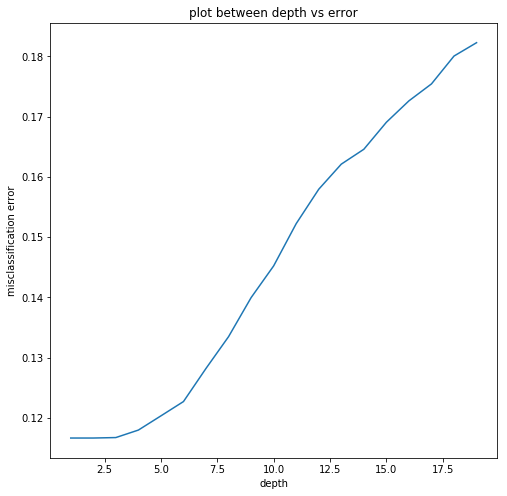

**********************************************************************

accuracy= 86.32908860590706
**********************************************************************

confusion matrix--


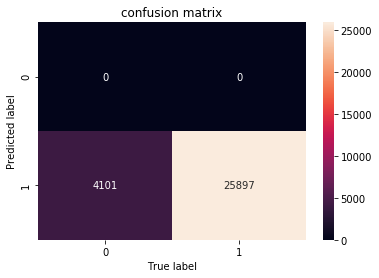

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.86      0.93     29998

avg / total       1.00      0.86      0.93     29998

**********************************************************************



In [56]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20,  n_jobs=-1, scoring='accuracy', x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [57]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


#### **Observation-**
* we can't find the important words for avg word2vec

### **4.2 Apply GridSearchCV, scoring='f1', on DecisionTreeClassifier for Avg word2vec**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.6min finished


duration in cross validation= 0:09:43.133561
**********************************************************************

optimal depth 1
**********************************************************************



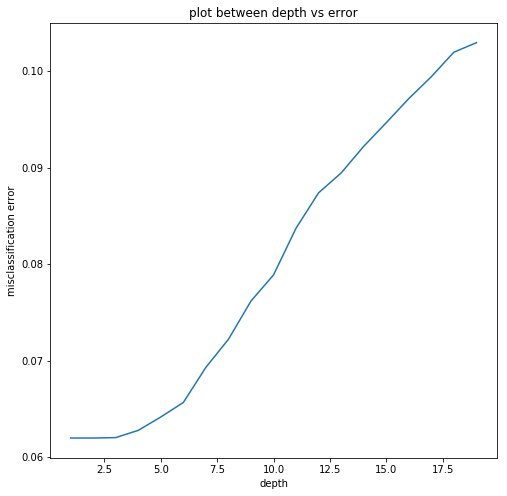

**********************************************************************

accuracy= 86.32908860590706
**********************************************************************

confusion matrix--


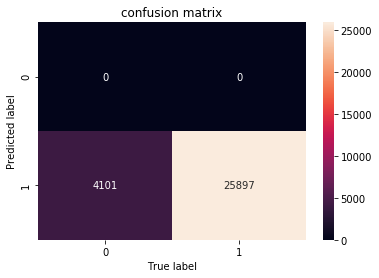

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.86      0.93     29998

avg / total       1.00      0.86      0.93     29998

**********************************************************************



In [59]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, n_jobs=-1, scoring='f1', x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [60]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


#### **Observation-**
* we can't find the important words for avg word2vec
* we can choose max_depth=1 as a good hyperparameter for word2vec


**saving graph**

In [29]:
clf=DecisionTreeClassifier(max_depth=1)
clf.fit(vectors,y_train_word)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("word2vec_graph") 


'word2vec_graph.pdf'

## **5. Tfidf word2vec**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [31]:
features=tfidf.get_feature_names()
len(features)
#features

27165

In [32]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [33]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [34]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[]

In [35]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [36]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
x_test_tf_word=np.delete(x_test_tf_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

In [37]:
len(y_train_word)

69978

### **5.1 Apply GridSearchCV, scoring='accuracy', on DecisionTreeClassifier for Tfidf word2vec**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.7min finished


duration in cross validation= 0:09:48.182368
**********************************************************************

optimal depth 1
**********************************************************************



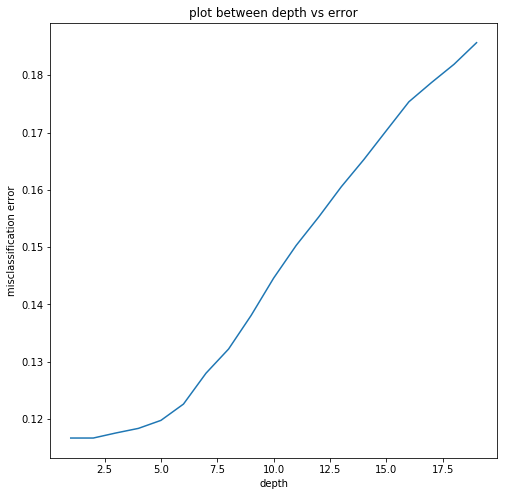

**********************************************************************

accuracy= 86.32908860590706
**********************************************************************

confusion matrix--


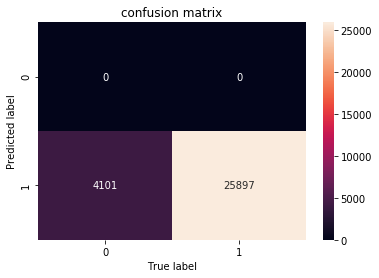

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.86      0.93     29998

avg / total       1.00      0.86      0.93     29998

**********************************************************************



In [69]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=20, n_jobs=-1, scoring='accuracy', x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [70]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


#### **Observation-**
* we can't find important words for tfidf word2vec

### **5.2 Apply GridSearchCV, scoring='f1', on DecisionTreeClassifier for Tfidf word2vec**

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.8min finished


duration in cross validation= 0:09:52.993966
**********************************************************************

optimal depth 1
**********************************************************************



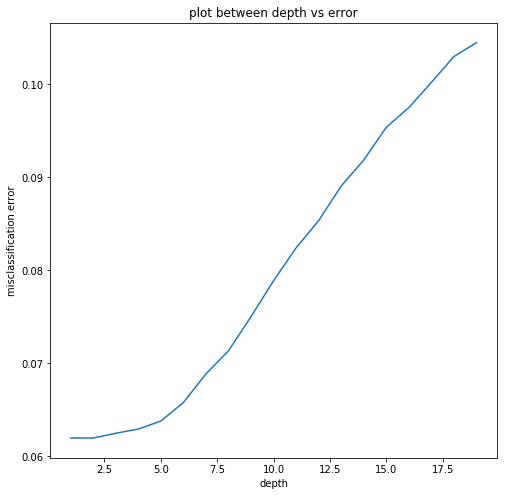

**********************************************************************

accuracy= 86.32908860590706
**********************************************************************

confusion matrix--


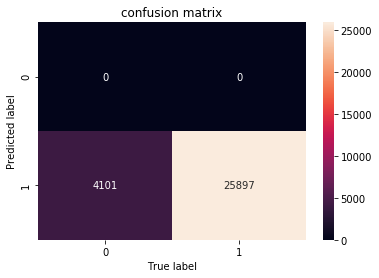

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.86      0.93     29998

avg / total       1.00      0.86      0.93     29998

**********************************************************************



In [71]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val( n=20, n_jobs=-1, scoring='f1', x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [72]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(tfidf_vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


#### **Observation-**
* we can't find important words for tfidf word2vec
* we can choose max_depth=14 as a good hyperparameter for Tfidf Word2vec

#### **saving graph**

In [38]:
clf=DecisionTreeClassifier(max_depth=1)
clf.fit(tfidf_vectors,y_train_word)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tfidf_word2vec_graph") 


'tfidf_word2vec_graph.pdf'

# **6. Performance Table**

| sno 	| featurization  	| scoring  	| optimal depth 	| accuracy 	| TNR    	| TPR    	| f1-score 	|
|-----	|----------------	|----------	|---------------	|----------	|--------	|--------	|----------	|
| 1   	| Bag of words   	| accuracy 	| 13            	| 84.7792  	| 0.1960 	| 0.9856 	| 0.89     	|
| 2   	| Bag of words   	| f1    	| 10            	| 84.6748  	| 0.1795 	| 0.9878 	| 0.89     	|
| 3   	| Tfidf          	| accuracy 	| 10             	| 84.6538  	| 0.1877 	| 0.9858 	| 0.89     	|
| 4   	| Tfidf          	| f1       	| 9             	| 84.6272  	| 0.1729 	| 0.9887 	| 0.89     	|
| 5   	| Avg word2vec   	| accuracy 	| 1             	| 86.3290  	| 0.0    	| 1.0   	| 0.93     	|
| 6   	| Avg word2vec   	| f1    	| 1             	| 86.3290  	| 0.0    	| 1.0   	| 0.93     	|
| 7   	| Tfidf Word2Vec 	| accuracy 	| 1             	| 86.3290  	| 0.0    	| 1.0   	| 0.93     	|
| 8   	| Tfidf Word2Vec 	| f1       	| 1             	| 86.3290  	| 0.0    	| 1.0    	| 0.93     	|

# **Conclusion-**
* We have applied Decision Tree on amazon fine food review.
* Normalization should have no impact on the performance of a decision tree. So we didn't use it.
* We applied four featurization techniques- BoW, Tfidf, Avg word2vec and Tfidf word2vec for Decision Tree.
* As we can see that TNR is so bad especially in case of avg word2vec model and Tfidf word2vec model, seems like dumb model.
* Even in case of Bag of words and Tfidf , TNRs have some value but accuracy is lower than word2vec model which is acting like a dumb model.
* So we can conclude that decision tree is not working well for this amazon fine food review dataset (text dataset).